In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from time import time
import json
import seaborn as sns
from numpy import asarray
from numpy import save
from numpy import load
import pickle
import joblib
import scipy
from sklearn.metrics import mean_squared_error

Set seed:

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
sns.set_style("white")

In [4]:
sns.set_style("white")

### Load Data

In [5]:
cc4_data = pd.read_csv("../data/ts_data.csv") 

with open ('../data/lstm_mlp/label_keys', 'rb') as fp:
    label_keys = pickle.load(fp)
with open ('../data/lstm_mlp/feature_keys', 'rb') as fp:
    feature_keys = pickle.load(fp)    

train_unsc = pd.read_pickle("../data/lstm_mlp/train_unsc_ts.pkl")
valid_unsc = pd.read_pickle("../data/lstm_mlp/valid_unsc_ts.pkl")
test_unsc = pd.read_pickle("../data/lstm_mlp/test_unsc_ts.pkl")
all_train_unsc = pd.read_pickle("../data/lstm_mlp/all_train_unsc_ts.pkl")

scaler_x = joblib.load("../data/lstm_mlp/scaler_all_train_x.save") 
scaler_y = joblib.load("../data/lstm_mlp/scaler_all_train_y.save") 

train_norm = pd.read_pickle("../data/lstm_mlp/train_scaled.pkl")
valid_norm = pd.read_pickle("../data/lstm_mlp/valid_scaled.pkl")
test_norm = pd.read_pickle("../data/lstm_mlp/test_scaled.pkl")
all_train_norm = pd.read_pickle("../data/lstm_mlp/all_train_scaled.pkl")

train_x = load('../data/lstm_mlp/train_x_norm.npy')
train_y = load('../data/lstm_mlp/train_y_norm.npy')
valid_x = load('../data/lstm_mlp/valid_x_norm.npy')
valid_y = load('../data/lstm_mlp/valid_y_norm.npy')
test_x = load('../data/lstm_mlp/test_x_norm.npy')
test_y = load('../data/lstm_mlp/test_y_norm.npy')
all_train_x = load('../data/lstm_mlp/all_train_x_norm.npy')
all_train_y = load('../data/lstm_mlp/all_train_y_norm.npy')

In [6]:
water_keys = ['WasserZ4FsInLproMin_integr',
 'WasserZ4LsInLproMin_integr',
 'WasserZ2bFsInLproMin_integr',
 'WasserZ2bLsInLproMin_integr',
 'WasserZ3bFsInLproMin_integr',
 'WasserZ1FsInLproMin_integr',
 'WasserZ3bLsInLproMin_integr',
 'WasserZ1LsInLproMin_integr',
 'WasserZ3aFsInLproMin_integr',
 'WasserZ3aLsInLproMin_integr',
 'WasserZ2aLsInLproMin_integr',
 'WasserZ2aFsInLproMin_integr',
 'WasserZ5LsInLproMin_integr',
 'WasserZ5FsInLproMin_integr',
 ]

feature_future_keys = [ele for ele in feature_keys if ele not in water_keys]

columns = cc4_data.columns.to_list()

### Load Model

In [7]:
model = keras.models.load_model("../data/lstm_mlp/lstm_models/LSTMDropout_model_test")

## First Optimization

Set time point and steps in the future to optimize:

In [8]:
seq_id = '471719_str_1' 
dt = 3   ## Since we only have limited data, we use 3 instead of 30 (as with whole data) time steps to optimize 
now = '2019-05-15 12:39:00+00:00'

### Looking at actual water for t+3:

In [9]:
data = cc4_data[cc4_data['seq_id']==seq_id].reset_index(drop=True)
position = data[data['DATE_TIME']==now].index
real_water = data.loc[position[0]:position[0]+3][water_keys].reset_index(drop=True)

Text(0.5, 1.0, 'Real Water')

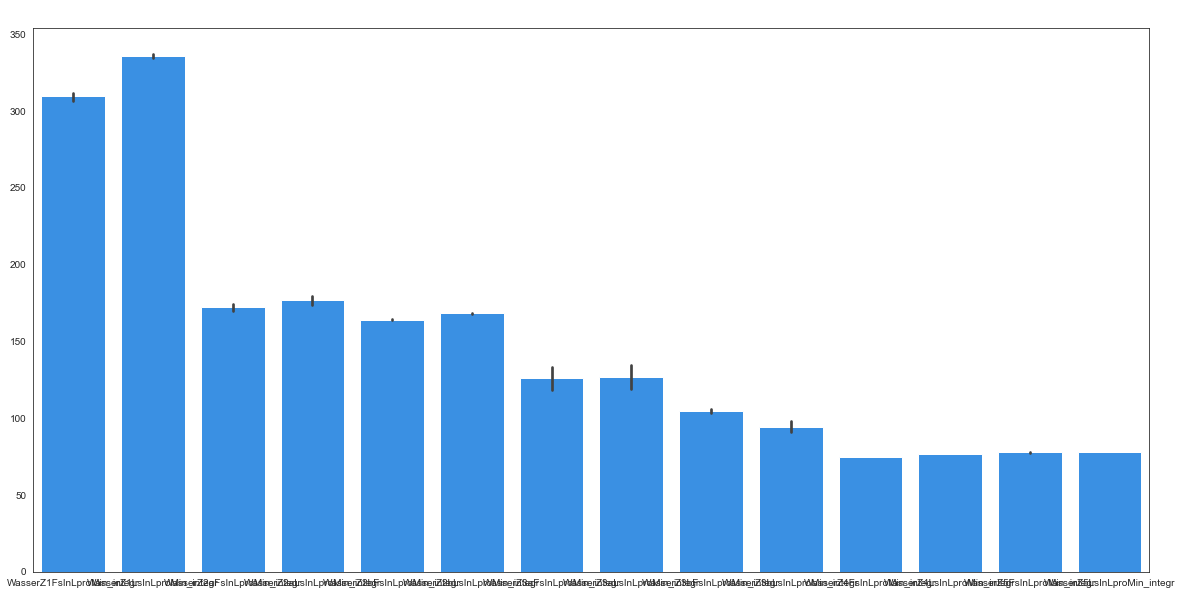

In [10]:
fig, axes = plt.subplots( figsize=(20, 10),  sharex=True)
sns.barplot(data=real_water[sorted(water_keys)], color='dodgerblue')
plt.title('Real Water', fontsize=20, color='white') 

### Function for optimization:

Pseudocode for optimization, further explanation follows
    # def getData(now, dt):
                # data for LSTM
                # features_past (t...t-4):
                # features_future (except water) (t+1...t+3) 
                return features_past, features_future
 
    # def predict(W, features_past, features_future):
                # input = concat(features_past, concat(features_future, W))
                # for 5er-Slice in input :
                 T[t] = model.predict(5er-Slice)
                # return T
 
    # def cost(W, T_soll, features_past, features_future):
                # T = predict(W, features_past, features_future)
                # return sum(abs(T-T_soll))
                
    # def findBestWater(now, dt):
                # features_past*, features_future* = getData(now, dt)
                # W0 = mean of water for t...t-4
                # W = optimize.minimize(lambda W: cost(W,T_soll*, features_past*,      
                # features_future*),x0=W0)    
               #  return W

Function to get the data
- all attributes for the features for t...t-4:features_past
- all except the water attributes for the features for t+1...t+3:  features_future
- casting target temperature: T_soll
- scale all values between 0 and 1

In [11]:
def getData(now, dt, cc4_data, seq_id):
    data = cc4_data[cc4_data['seq_id']==seq_id].reset_index(drop=True)
    position = data[data['DATE_TIME']==now].index
    
    features_past = data.loc[(position[0]-4):position[0]]  ##features for past
    features_past = features_past[feature_keys]
    features_past_norm = pd.DataFrame(scaler_x.transform(features_past), columns=feature_keys)
    features_future = data.loc[position[0]+1:position[0]+3]  ## features for future
    features_future = features_future[feature_keys]
    features_future_norm = pd.DataFrame(scaler_x.transform(features_future), columns=feature_keys)
    features_future_norm = features_future_norm[feature_future_keys]
    T_soll = np.array([cc4_data['ZielTempTreiberInC'].loc[position[0]:position[0]+3],
          cc4_data['ZielTempTreiberInC'].loc[position[0]:position[0]+3]]).transpose() ##casting target temperature
    T_soll_norm = scaler_y.transform(T_soll)
    return features_past_norm, features_future_norm, T_soll_norm

Function to predict temperature:
- combine optimized water W for future with features_future to features_future_new
- combinde features_future_new and features_past to input_arr: All the features to make predictions for considered time steps
- use model.predict to make prediction with model

In [12]:
def predict(W, features_past, features_future):
    if isinstance(W, np.ndarray):
        W = pd.DataFrame(W.reshape((3,14)), columns=water_keys)
        
    features_future_new = pd.concat([features_future, W], axis=1).reindex(feature_keys, axis=1)
    input_arr = pd.concat([features_past,features_future_new], axis=0)
    features_slice = []
    feature_slice = [input_arr[i:i+5] for i in range(len(input_arr)-(5-1))]
    
    features= np.stack(feature_slice)
        
    T = model.predict(features)
    return T

objective function:
- mean absolute error (MAE) between predicted temperature (calculated with function to predict temperature) and casting target temperature

In [13]:
def cost(W, T_soll, features_past, features_future):
    T = predict(W, features_past, features_future)
    return  np.mean(sum(abs(T-T_soll)))

Nelder-Mead optimizer:
- get all the data with get_data
- use average cooling water quantities for Initial guess W0
- use Nelder-Mead to optimize water quantities W for t+1...t+3, by minimizing objective function cost() (MAE between predicted and target temperature) where W is used.
- return best W

In [14]:
def findBestWater(now, dt, cc4_data, strang_id):
    features_past, features_future, T_soll = getData(now, dt, cc4_data, seq_id)
    w = features_past[water_keys].mean().to_numpy().reshape((1,14)) ## water quantites fot t...t-4
    W0 = pd.DataFrame(np.repeat(w, repeats=dt, axis=0), columns=water_keys) ## initial guess
    W = scipy.optimize.minimize(lambda W: cost(W, T_soll, features_past, features_future) , x0=W0,
                                options={ 'disp':True,  'adaptive':True,},  ##optimize W by minimizing 
                                method = 'Nelder-Mead',                 ## MAE between T_pred and T_soll
                               )    
    return W

#### Either run optimization:

In [15]:
# np.random.seed(42)
# W_471719_str_1 = findBestWater(now, dt, cc4_data, seq_id)

In [16]:
# ## save to pickle
# with open("../data/water_optimized.pkl", 'wb') as f:
#     pickle.dump(W_471719_str_1, f)

#### Or load results

In [2]:
with open ('../data/water_optimized.pkl', 'rb') as fp:
    W_471719_str_1 = pickle.load(fp)

### Optimized water

In [18]:
w_opt = pd.DataFrame(W_471719_str_1.x.reshape((3,14)), columns=water_keys)

features_past, features_future, T_soll= getData(now, dt, cc4_data, seq_id)

df_new_f = pd.concat([features_future[feature_future_keys], w_opt], axis=1).reindex(feature_keys, axis=1)
water_opt_unsc = pd.DataFrame(scaler_x.inverse_transform(df_new_f), columns=feature_keys)[water_keys]

Since limited data, the resulting water quantites are not usefull.

Text(0.5, 1.0, 'Real Water')

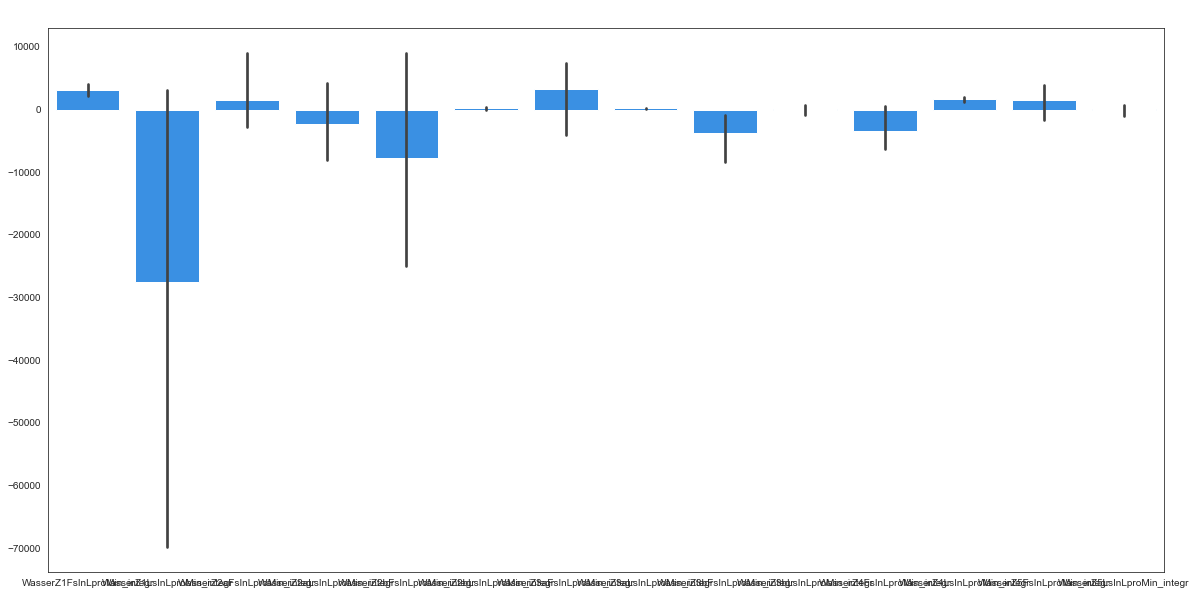

In [19]:
fig = plt.figure( figsize=(20, 10))
sns.barplot(data=water_opt_unsc[sorted(water_opt_unsc.columns)], color='dodgerblue')
plt.title('Real Water', fontsize=20, color='white') 

### W0

In [20]:
w = features_past[water_keys].mean().to_numpy().reshape((1,14))
W0 = pd.DataFrame(np.repeat(w, repeats=dt, axis=0), columns=water_keys)

data = cc4_data[cc4_data['seq_id']==seq_id].reset_index(drop=True)
position = data[data['DATE_TIME']==now].index
features_past_unsc = data.loc[(position[0]-4):position[0]]
features_past_unsc = features_past_unsc[feature_keys]
w_unsc = features_past_unsc[water_keys].mean().to_numpy().reshape((1,14))
W0_unsc = pd.DataFrame(np.repeat(w_unsc, repeats=dt, axis=0), columns=water_keys)

Text(0.5, 1.0, 'W0')

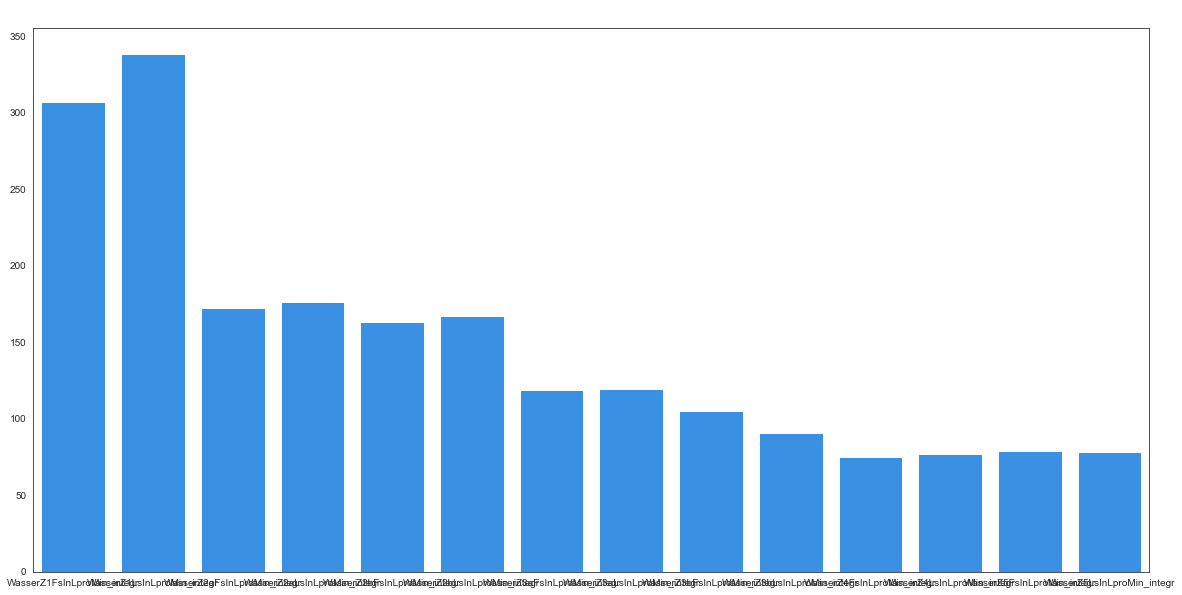

In [21]:
fig, axes = plt.subplots( figsize=(20, 10),  sharex=True)
sns.barplot(data=W0_unsc[sorted(water_keys)], color='dodgerblue')
plt.title('W0', fontsize=20, color='white') 

In [22]:
real_water.rename(columns={'WasserZ4FsInLproMin_integr': 'Z4_FS_measured',
                            'WasserZ4LsInLproMin_integr': 'Z4_LS_measured',
                           'WasserZ2bFsInLproMin_integr': 'Z2b_FS_measured',
                            'WasserZ2bLsInLproMin_integr': 'Z2b_LS_measured',
                           'WasserZ3bFsInLproMin_integr': 'Z3b_FS_measured',
                            'WasserZ3bLsInLproMin_integr': 'Z3b_LS_measured',
                           'WasserZ3aFsInLproMin_integr': 'Z3a_FS_measured',
                            'WasserZ3aLsInLproMin_integr': 'Z3a_LS_measured',
                           'WasserZ2aFsInLproMin_integr': 'Z2a_FS_measured',
                            'WasserZ2aLsInLproMin_integr': 'Z2a_LS_measured',
                           'WasserZ5FsInLproMin_integr': 'Z5_FS_measured',
                            'WasserZ5LsInLproMin_integr': 'Z5_LS_measured',
                             'WasserZ1FsInLproMin_integr':'Z1_FS_measured',
                            'WasserZ1LsInLproMin_integr':'Z1_LS_measured',
                           }, inplace=True)

In [23]:
water_opt_unsc.rename(columns={'WasserZ4FsInLproMin_integr': 'Z4_FS_optimized',
                            'WasserZ4LsInLproMin_integr': 'Z4_LS_optimized',
                           'WasserZ2bFsInLproMin_integr': 'Z2b_FS_optimized',
                            'WasserZ2bLsInLproMin_integr': 'Z2b_LS_optimized',
                           'WasserZ3bFsInLproMin_integr': 'Z3b_FS_optimized',
                            'WasserZ3bLsInLproMin_integr': 'Z3b_LS_optimized',
                           'WasserZ3aFsInLproMin_integr': 'Z3a_FS_optimized',
                            'WasserZ3aLsInLproMin_integr': 'Z3a_LS_optimized',
                           'WasserZ2aFsInLproMin_integr': 'Z2a_FS_optimized',
                            'WasserZ2aLsInLproMin_integr': 'Z2a_LS_optimized',
                           'WasserZ5FsInLproMin_integr': 'Z5_FS_optimized',
                            'WasserZ5LsInLproMin_integr': 'Z5_LS_optimized',
                                 'WasserZ1FsInLproMin_integr':'Z1_FS_optimized',
                            'WasserZ1LsInLproMin_integr':'Z1_LS_optimized',
                           }, inplace=True)

## Compare prediction with optimized water to original prediction

In [24]:
y_opt = scaler_y.inverse_transform(predict(w_opt, features_past, features_future))

T_soll_unsc = scaler_y.inverse_transform(T_soll)

y_W0 = scaler_y.inverse_transform(predict(W0, features_past, features_future))

data = cc4_data[cc4_data['seq_id']==seq_id].reset_index()
position = data[data['DATE_TIME']==now].index
real_temp = data.loc[position[0]:position[0]+3][label_keys].to_numpy()

##### RMSE measured Temperature to casting target temperature

In [25]:
np.sqrt(mean_squared_error( real_temp, T_soll_unsc ))  

56.46486296452486

##### RMSE predicted Temperature with optimized water to casting target temperature

In [26]:
np.sqrt(mean_squared_error( y_opt, T_soll_unsc ))  

45.221886593946664

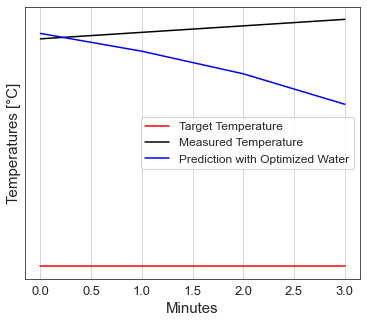

In [27]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
ax1.plot(T_soll_unsc[:,:1], color='red', label='Target Temperature')
ax1.plot(real_temp[:,:1], color='black', label='Measured Temperature')
ax1.plot(y_opt[:,:1], color='blue', label='Prediction with Optimized Water')
ax1.set_xlabel('Minutes', fontsize=15)
ax1.set_ylabel('Temperatures [°C]', fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
ax1.legend(loc='best')
ax1.legend(prop={'size': 12})
#ax1.set_ylim(710, 725)
ax1.set(yticks=[]) 
ax1.grid()



### Compare water quantities

#### Original water quantities

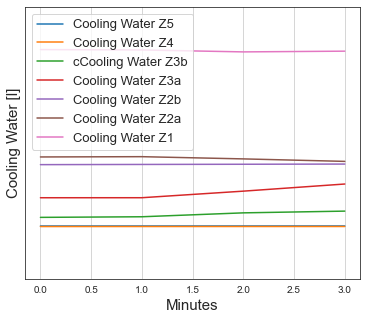

In [28]:
seq_number = '474261_str_1'
fig, (ax1) = plt.subplots(1,1, figsize=(6, 5))
sns.lineplot(data=real_water.reset_index(drop=True),
             y='Z5_LS_measured',x=real_water.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z5')
sns.lineplot(data=real_water.reset_index(drop=True),
             y='Z4_LS_measured',x=real_water.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z4')
sns.lineplot(data=real_water.reset_index(drop=True),
             y='Z3b_LS_measured',x=real_water.reset_index(drop=True).index,
             ax=ax1, label='cCooling Water Z3b')
sns.lineplot(data=real_water.reset_index(drop=True),
             y='Z3a_LS_measured',x=real_water.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z3a')
sns.lineplot(data=real_water.reset_index(drop=True),
             y='Z2b_LS_measured',x=real_water.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z2b')
sns.lineplot(data=real_water.reset_index(drop=True),
             y='Z2a_LS_measured',x=real_water.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z2a')
sns.lineplot(data=real_water.reset_index(drop=True),
             y='Z1_LS_measured',x=real_water.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z1')
ax1.set_ylabel('Cooling Water [l]', fontsize=15)
ax1.xaxis.grid(True)
ax1.set_ylim(0, 400)
ax1.set(yticks=[]) 
ax1.set_xlabel('Minutes', fontsize=15)
ax1.legend(loc='upper left', prop={'size': 13})


#### Optimized water quantities

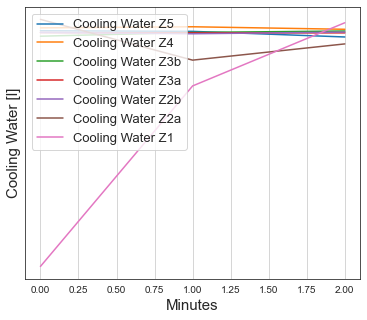

In [29]:
seq_number = '474261_str_1'
fig, (ax1) = plt.subplots(1,1, figsize=(6, 5))
sns.lineplot(data=water_opt_unsc.reset_index(drop=True),
             y='Z5_LS_optimized',x=water_opt_unsc.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z5')
sns.lineplot(data=water_opt_unsc.reset_index(drop=True),
             y='Z4_LS_optimized',x=water_opt_unsc.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z4')
sns.lineplot(data=water_opt_unsc.reset_index(drop=True),
             y='Z3b_LS_optimized',x=water_opt_unsc.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z3b')
sns.lineplot(data=water_opt_unsc.reset_index(drop=True),
             y='Z3a_LS_optimized',x=water_opt_unsc.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z3a')
sns.lineplot(data=water_opt_unsc.reset_index(drop=True),
             y='Z2b_LS_optimized',x=water_opt_unsc.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z2b')
sns.lineplot(data=water_opt_unsc.reset_index(drop=True),
             y='Z2a_LS_optimized',x=water_opt_unsc.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z2a')
sns.lineplot(data=water_opt_unsc.reset_index(drop=True),
             y='Z1_LS_optimized',x=water_opt_unsc.reset_index(drop=True).index,
             ax=ax1, label='Cooling Water Z1')
ax1.set_ylabel('Cooling Water [l]', fontsize=15)
ax1.xaxis.grid(True)
ax1.set(yticks=[]) 
ax1.set_xlabel('Minutes', fontsize=15)
ax1.legend(loc='upper left', prop={'size': 13})
